# Data Generation

## Configuration

In [1]:
IMAGE_SIZE = 64
COLORS = ['red', 'orange', 'green', 'purple', 'blue', 'cyan', 'brown', 'yellow']
SHAPES = ['circle', 'square', 'triangle']
# https://www.rapidtables.com/web/color/RGB_Color.html
COLOR_DICT = {
    'red': [255, 0, 0],
    'orange': [255, 165, 0],
    'green': [0, 128, 0],
    'purple': [128, 0, 128],
    'blue': [0, 0, 255],
    'cyan': [0, 255, 255],
    'brown': [165, 42, 42],
    'yellow': [255, 255, 0],
}
TOTAL_COUNT = 25000
# perturbation
DIST_LOCATION = 0
DIST_SCALE = 32
DATASET_NAME = 'dataset-25000'

## Generation

In [2]:
import numpy as np
from PIL import Image, ImageDraw
from datasets import Dataset, DatasetDict

np.random.seed(42)

def color_perturb(color):
    color = np.array(color) + np.random.normal(DIST_LOCATION, DIST_SCALE, (3))
    m = max(255, color.max())
    color = ((color / m) * 255).astype(np.uint8)
    return tuple(color)

def generate_random_shapes_image(size):
    img = Image.new('RGB', (size, size), 'black')
    draw = ImageDraw.Draw(img)

    shape_type = np.random.choice(SHAPES)
    color_name = np.random.choice(COLORS)
    color = color_perturb(COLOR_DICT[color_name])
    config = {'shape': shape_type, 'color_name': color_name, 'color': color}

    if shape_type == 'circle':
        radius = np.random.randint(10, size//2 - 1)
        center = np.random.randint(radius + 1, size - radius - 1, size=2)
        draw.ellipse([tuple(center - radius), tuple(center + radius)], fill=color)
        config['radius'] = radius 
        config['center'] = center
    elif shape_type == 'square':
        start = tuple(np.random.randint(0, size//2, size=2))
        side_length = np.random.randint(size//4, size//2)
        end = tuple(start + np.repeat(side_length, 2))
        angle = np.random.randint(0, 360)
        rect_img = Image.new('RGBA', (size, size), (0, 0, 0, 0))
        rect_draw = ImageDraw.Draw(rect_img)
        rect_draw.rectangle([start, end], fill=color)
        rotated_rect_img = rect_img.rotate(angle, expand=False)
        img.paste(rotated_rect_img, (0, 0), rotated_rect_img)
        config['start'] = start
        config['side_length'] = side_length
        config['angle'] = angle
    elif shape_type == 'triangle':
        side_length = np.random.randint(10, size//2)
        angle = np.random.randint(0, 360)
        triangle_img = Image.new('RGBA', (size, size), (0, 0, 0, 0))
        triangle_draw = ImageDraw.Draw(triangle_img)
        center = np.random.randint(side_length, size//2, size=2)
        vertices = [
            (center[0], center[1] - side_length // np.sqrt(3)),
            (center[0] - side_length // 2, center[1] + side_length // (2 * np.sqrt(3))),
            (center[0] + side_length // 2, center[1] + side_length // (2 * np.sqrt(3)))
        ]
        triangle_draw.polygon(vertices, fill=color)
        rotated_triangle_img = triangle_img.rotate(angle, expand=False)
        img.paste(rotated_triangle_img, (0, 0), rotated_triangle_img)
        config['center'] = center
        config['side_length'] = side_length
        config['angle'] = angle
    
    return (img, config)

# Generate 100 images with random shapes
images = []
configs = []
for i in range(TOTAL_COUNT):
    (img, config) = generate_random_shapes_image(IMAGE_SIZE)
    images.append(img)
    configs.append(config)

# Create a Hugging Face dataset
dataset = Dataset.from_dict({'image': images, 'config': configs})
dataset_dict = DatasetDict({'train': dataset})

# Save the dataset to Hugging Face
dataset_dict.save_to_disk(DATASET_NAME)

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

## Visualization

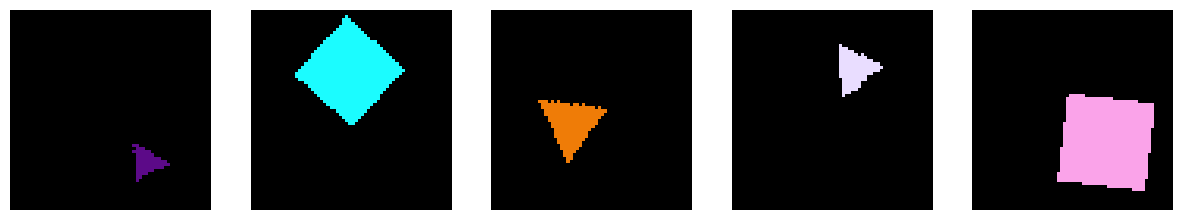

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk

# Load the dataset from disk
dataset_dict = load_from_disk(DATASET_NAME)
dataset = dataset_dict['train']

# Visualize a few examples from the dataset
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i in range(num_examples):
    img = dataset[i]['image']
    img = np.array(img)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

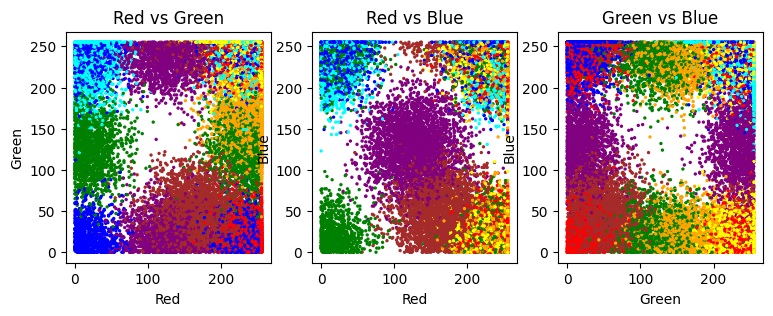

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk

# Load the dataset from disk
dataset_dict = load_from_disk(DATASET_NAME)
dataset = dataset_dict['train']

# Extract color data points from the images
colors = []
original_colors = []
for i in range(len(dataset)):
    colors.append(dataset[i]['config']['color'])
    original_colors.append(COLOR_DICT[dataset[i]['config']['color_name']])

colors = np.array(colors)
original_colors = np.array(original_colors)

# Plot the distribution of the color via MPL
fig, axes = plt.subplots(1, 3, figsize=(9, 3))


axes[0].scatter(colors[:, 0], colors[:, 1], c=original_colors / 255.0, s=2)
axes[0].set_xlabel('Red')
axes[0].set_ylabel('Green')
axes[0].set_title('Red vs Green')

axes[1].scatter(colors[:, 0], colors[:, 2], c=original_colors / 255.0, s=2)
axes[1].set_xlabel('Red')
axes[1].set_ylabel('Blue')
axes[1].set_title('Red vs Blue')

axes[2].scatter(colors[:, 1], colors[:, 2], c=original_colors / 255.0, s=2)
axes[2].set_xlabel('Green')
axes[2].set_ylabel('Blue')
axes[2].set_title('Green vs Blue')

plt.show()
